# CNN_Plant_Seedling_Classification


此範例會使用模組化的軟體設計方法，它將一個大型的程式或專案拆分成更小、更容易管理的模塊或組件。每個模塊執行特定的功能或處理特定的任務，並且可以獨立開發、測試和維護。這樣的設計有助於提高程式碼的可讀性、可重用性和可維護性，並且讓不同團隊的開發者能夠協作更輕鬆。在PyTorch中，模組化通常表現為創建獨立的模型、函數和類別，每個模塊負責特定的任務，並且可以輕鬆組合在一起以構建更大的深度學習模型。

本次課程將會把pytorch訓練流程分成以下幾個模組來教學:
1. `Dataset`
2. `Dataloader`
3. `Model`
4. `Train` Function
5. `Valid` Function
6. `Plot Curve` Function
7. `Predict` Function
8. `Main` Function
9. `Addition` Customize model

## Download Datasets

此範例使用kaggle上的[Plant Seedlings Classification](https://www.kaggle.com/c/plant-seedlings-classification)資料集，請先至網站中下載`plant-seedlings-classification.zip`，透過`google.colab`套件，我們可以讓 Colab 上的程式直接讀取自己的雲端硬碟。


執行下面的code之前，請先確保自己的google drive中已經有`plant-seedlings-classification.zip`檔案，並確保檔案位置正確。

掛載自己的google drive後，雲端硬碟的根目錄為: `/content/gdrive/MyDrive/`



In [1]:
import os
import zipfile

data_dir = './plant_seedlings_classification/' # dataset's dir you want to unzip

if not os.path.exists(data_dir):
  zip_dir = './plant-seedlings-classification.zip' # your zip file's dir

  with zipfile.ZipFile(zip_dir, 'r') as zip_ref:
      zip_ref.extractall(data_dir)


## Import Package

In [2]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as tsfm
from torchvision.datasets import ImageFolder

import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path
from IPython import display

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True

## Config
Config of Hyperparameter

In [3]:
# Set Hyperparameters
batch_size = 64
epochs = 50
learning_rate = 0.001
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

## 1. Custom Pytorch Dataset


A `Dataset` in Pytorch should have three methods:

1. `__init__`: Read data & preprocess
2. `__len__`: return a integer indicating the size of the dataset
3. `__getitem__`: given an index `idx`, return the `idx`-th sample

In our case, the download data is structured as:
```
├── train
│   ├── Black-grass (Class name)
│   │   ├── 0050f38b3.png
│   │   ├── 0183fdf68.png
│   │   ├── 0260cffa8.png
│   │   ├── ...
│   └── Charlock
│   │   ├── 022179d65.png
│   │   ├── 02c95e601.png
│   │   ├── 04098447d.png
│   │   ├── ...
│   └── ...
├── test
│   ├── 0021e90e4.png
│   ├── 003d61042.png
│   ├── 007b3da8b.png
│   ├── ...
```

We can simply find all the pngs and load them into memory when needed. In common practice, dataset will receive one or more `torchvision.transforms` which transform the png (loaded as `PIL.Image`) into pytorch tensor.

`Dataloader` batchify the samples in dataset, i.e. builds mini-batch from the data return by dataset's `__getitem__` . We then iterate the `Dataloader` for training.

Usually `Dataloader` is finite and will run of mini-batches when we have seen all samples in `Dataset` once. However, to write our code easily, we can create an infinite `Sampler` that can guide the batchification process in `Dataloader` and make `Dataloader` supply mini-batches infinitely.

In [4]:
class Train_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = ImageFolder(root=root_dir, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

class Pred_data(Dataset):
    def __init__(self, root_dir, transform=None):
        self.img_paths = list(Path(root_dir).glob('*.png'))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        img = self.transform(img)
        img = img.unsqueeze(0)
        return img

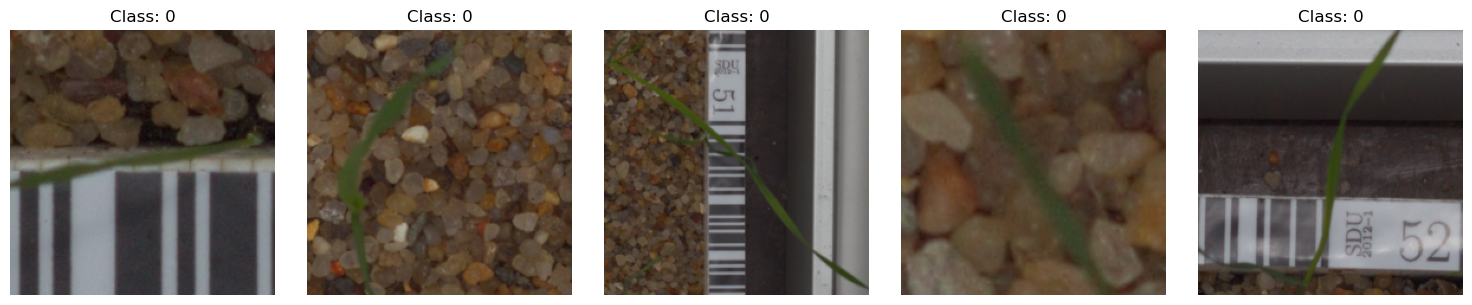

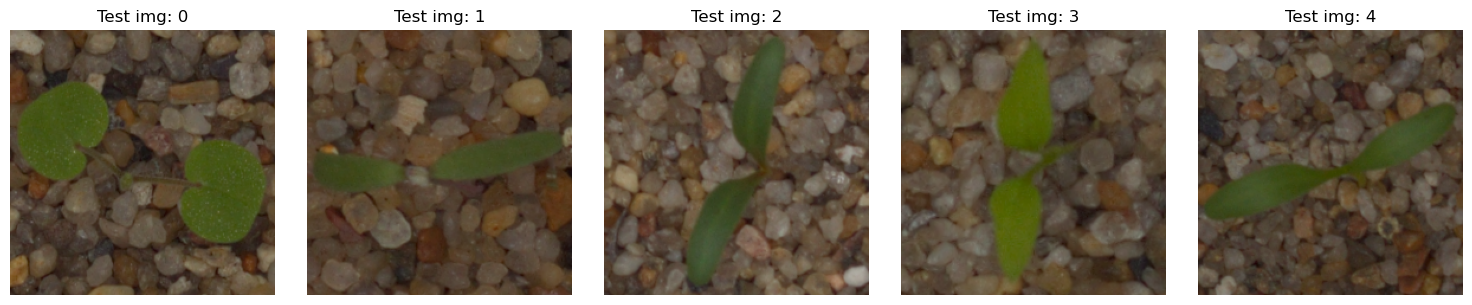

In [5]:
# visualize dataset item for debug
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])

whole_set = Train_data(
    root_dir=train_dir,
    transform=transform
)

test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i, (img, label) in enumerate(whole_set):
    axs[i].imshow(img.permute(1, 2, 0))
    axs[i].set_title(f'Class: {label}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i, img in enumerate(test_set):
    axs[i].imshow(img[0].permute(1, 2, 0))
    axs[i].set_title(f'Test img: {i}')
    axs[i].axis('off')

    num_images_to_display -= 1
    if num_images_to_display == 0:
        break

plt.tight_layout()
plt.show()

## 2. Split train, valid set and Create Dataloader:


In [6]:
train_set, valid_set = random_split(whole_set, [0.8, 0.2])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## 3. Create Model

A `nn.Module` in Pytorch should have two methods:

1. `__init__`: Initialize your model & define layers
2. `forward`: Compute output of your Model



In [7]:
class resnet_50(nn.Module):
    def __init__(self, num_classes = 12):
        super(resnet_50, self).__init__()
        # pytorch built-in models
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # set model layers trainable
        for param in self.resnet50.parameters():
            param.requires_grad = True

        # redifine/customize last classification layer
        self.resnet50.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [8]:
# test model for debug

model = resnet_50(num_classes=12).cuda()
# print(model)
x = torch.rand(1, 3, 224, 224).cuda()
y = model(x)
print(x)
print(y)

tensor([[[[0.6671, 0.7646, 0.2732,  ..., 0.2299, 0.8501, 0.7446],
          [0.3145, 0.1770, 0.4947,  ..., 0.2657, 0.5151, 0.2777],
          [0.9626, 0.3276, 0.1024,  ..., 0.8075, 0.6732, 0.5020],
          ...,
          [0.1053, 0.0563, 0.9618,  ..., 0.0177, 0.8644, 0.9249],
          [0.2369, 0.6065, 0.7551,  ..., 0.8097, 0.0856, 0.5755],
          [0.6274, 0.9982, 0.7637,  ..., 0.2613, 0.3500, 0.0402]],

         [[0.5232, 0.1650, 0.3030,  ..., 0.7249, 0.3848, 0.7339],
          [0.5719, 0.4828, 0.7574,  ..., 0.5348, 0.9477, 0.0841],
          [0.2502, 0.2524, 0.9801,  ..., 0.1184, 0.5851, 0.6820],
          ...,
          [0.9749, 0.6790, 0.7742,  ..., 0.9642, 0.1267, 0.7451],
          [0.0856, 0.5820, 0.4309,  ..., 0.6179, 0.5303, 0.8151],
          [0.7269, 0.7204, 0.1821,  ..., 0.2500, 0.2649, 0.3273]],

         [[0.0077, 0.6897, 0.1437,  ..., 0.5420, 0.3801, 0.0750],
          [0.3946, 0.1692, 0.3127,  ..., 0.4402, 0.9574, 0.0358],
          [0.8982, 0.4166, 0.9354,  ..., 0

## 4. Define Train Function(for one epoch):


In [11]:
def train(model, criterion, optimizer, train_loader, epoch, total_epochs, batch_size):
    model.train()
    train_loss, train_acc = [], []

    tqdm_iter = tqdm(train_loader, desc="Epoch: {}/{} ({}%) | Training loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    for batch_idx, (data, label) in enumerate(tqdm_iter):
        data, target = data.cuda(), label.cuda()
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == target).float().mean().item()
        epoch_loss += loss.item()
        epoch_acc += acc

        tqdm_iter.set_description("Epoch: {}/{} ({}%) | Training loss: {:.6f} | Training Acc: {:.6f}".format(
        epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

In [12]:
# debug "train" function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss, acc = train(
    model,
    criterion,
    optimizer,
    train_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

1.6224318693081539 0.4596354166666667


## 5. Define Valid Function(for one epoch):


In [13]:
def valid(model, criterion, valid_loader, epoch, total_epochs, batch_size):
    model.eval()

    tqdm_iter = tqdm(valid_loader, desc="Epoch: {}/{} ({}%) | Valid loss: NaN".format(
    epoch, total_epochs, int(epoch/total_epochs * 100)), leave=False)
    epoch_loss, epoch_acc = 0.0, 0.0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(tqdm_iter):
            data, target = data.cuda(), label.cuda()
            output = model(data)
            loss = criterion(output, target)
            acc = (output.argmax(dim=1) == target).float().mean().item()
            epoch_loss += loss.item()
            epoch_acc += acc

            tqdm_iter.set_description("Epoch: {}/{} ({}%) | Valid loss: {:.6f} | Valid Acc: {:.6f}".format(
            epoch + 1, total_epochs, int((epoch+1)/total_epochs * 100), round(loss.item(), 6), round(acc, 6)))

    return epoch_loss / len(valid_loader), epoch_acc / len(valid_loader)

In [14]:
# debug "valid" function
criterion = nn.CrossEntropyLoss()
loss, acc = valid(
    model,
    criterion,
    valid_loader,
    epoch=1,
    total_epochs=1,
    batch_size=batch_size
)

print(loss, acc)

Epoch: 1/1 (100%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

1.9080110867818196 0.4158950626850128


## 6. Plot Learning Curve Function:

In [15]:
def Plot(title, ylabel, epochs, train_loss, valid_loss):
    plt.figure()
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.legend(['train', 'valid'], loc='upper left')

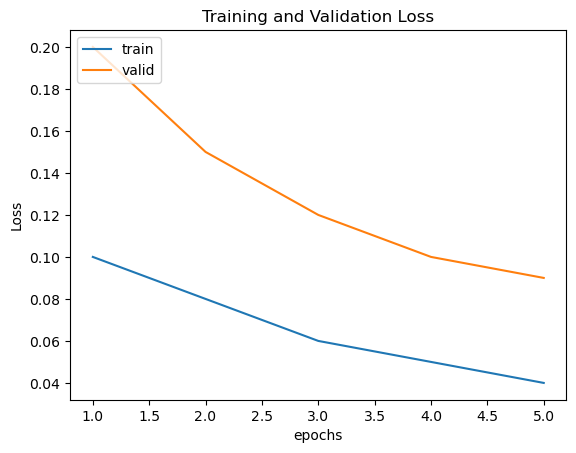

In [16]:
# debug "Plot" function
debug_epochs = [1, 2, 3, 4, 5]
debug_train_loss = [0.1, 0.08, 0.06, 0.05, 0.04]
debug_valid_loss = [0.2, 0.15, 0.12, 0.1, 0.09]

Plot("Training and Validation Loss", 'Loss', debug_epochs, debug_train_loss, debug_valid_loss)

plt.show()

## 7. Predict Function:

In [17]:
def predict(loader, model):
    model.eval()
    preds = []
    for data in tqdm(loader):
        pred = model(data.cuda())
        cls = torch.argmax(pred, dim=1)
        preds.append(cls)

    return preds

In [18]:
# Visualize Predict result
def view_pred_result(preds, num_images_to_display=5):
    labels = ['Black-grass', 'Charlock' , 'Cleavers' , 'Common Chickweed' , 'Common wheat' , 'Fat Hen' , 'Loose Silky-bent' , 'Maize' , 'Scentless Mayweed' , 'Shepherds Purse', 'Small-flowered Cranesbill' , 'Sugar beet']
    fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 3))
    for i, img in enumerate(test_set):
        axs[i].imshow(img[0].permute(1, 2, 0))
        axs[i].set_title(labels[preds[i].item()])
        axs[i].axis('off')

        num_images_to_display -= 1
        if num_images_to_display == 0:
            break

    plt.tight_layout()
    plt.show()

  0%|          | 0/794 [00:00<?, ?it/s]

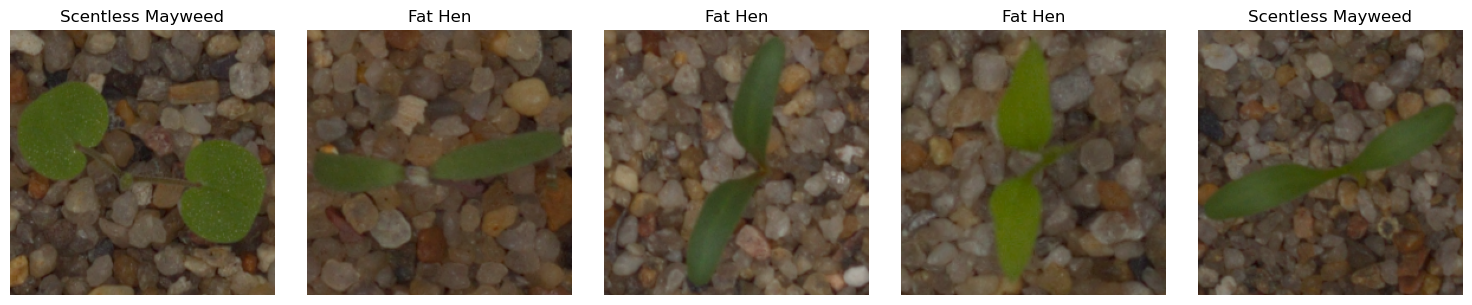

In [19]:
# debug "Predict" function & "View_Predict_result" function
test_dir = data_dir + 'test'
transform = tsfm.Compose([
    tsfm.Resize((224, 224)),
    tsfm.ToTensor(),
])
test_set = Pred_data(
    root_dir=test_dir,
    transform=transform
)
model = resnet_50(num_classes=12).cuda()

preds = predict(test_set, model)
view_pred_result(preds)

## 8. Main Function(training pipeline):
1. `Set Hyperparameters`: `batct_size`, `learning rate`, `epochs`...
2. `Initial`: initial `dataset`, `dataloader`, `model`
3. `Train`: Do train
4. `Valid`: Do valid
5. repeat `3.`  `4.` epochs times
6. `Plot curve`: Plot learning curve to observe the learning progress
7. `Predict`: Use the trained model to predict the results of the test set

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.6997221829990546, Avg train acc: 0.7765625


Epoch: 0/50 (0%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.673377643028895, Avg valid acc: 0.7960648139317831


Epoch: 1/50 (2%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.28381821264823276, Avg train acc: 0.9021701395511628


Epoch: 1/50 (2%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.8949676950772604, Avg valid acc: 0.7412037054697672


Epoch: 2/50 (4%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.2005147449672222, Avg train acc: 0.9328993062178293


Epoch: 2/50 (4%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2848658561706543, Avg valid acc: 0.8986496925354004


Epoch: 3/50 (6%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.1289530312642455, Avg train acc: 0.9584201395511627


Epoch: 3/50 (6%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3160051027933756, Avg valid acc: 0.8755401253700257


Epoch: 4/50 (8%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.09732492758582036, Avg train acc: 0.9686631947755814


Epoch: 4/50 (8%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3220274185140928, Avg valid acc: 0.9175925930341085


Epoch: 5/50 (10%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.09656351835777362, Avg train acc: 0.9682291666666667


Epoch: 5/50 (10%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.35950051645437875, Avg valid acc: 0.9032021601994832


Epoch: 6/50 (12%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0970700017331789, Avg train acc: 0.9666666666666667


Epoch: 6/50 (12%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.5095495839913686, Avg valid acc: 0.8565972208976745


Epoch: 7/50 (14%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0761298197088763, Avg train acc: 0.9765625


Epoch: 7/50 (14%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2245780885219574, Avg valid acc: 0.9315200606981914


Epoch: 8/50 (16%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.054805951992360255, Avg train acc: 0.9805555562178294


Epoch: 8/50 (16%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2235160638888677, Avg valid acc: 0.9410879651705424


Epoch: 9/50 (18%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.04478072457908032, Avg train acc: 0.9859375


Epoch: 9/50 (18%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.23763774832089743, Avg valid acc: 0.9275462985038757


Epoch: 10/50 (20%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.054623203014489266, Avg train acc: 0.9819444447755814


Epoch: 10/50 (20%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18551234205563863, Avg valid acc: 0.9464891990025838


Epoch: 11/50 (22%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.026009510938699045, Avg train acc: 0.9921875


Epoch: 11/50 (22%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.30414840765297413, Avg valid acc: 0.9375771601994832


Epoch: 12/50 (24%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.03475622571180186, Avg train acc: 0.99140625


Epoch: 12/50 (24%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.28790805240472156, Avg valid acc: 0.9167438268661499


Epoch: 13/50 (26%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.02732657483429648, Avg train acc: 0.9907118062178294


Epoch: 13/50 (26%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.19257036621371906, Avg valid acc: 0.9431712985038757


Epoch: 14/50 (28%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.018058967825587992, Avg train acc: 0.9934895833333334


Epoch: 14/50 (28%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2951540888597568, Avg valid acc: 0.9440200606981913


Epoch: 15/50 (30%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.045730073761660606, Avg train acc: 0.9865451395511627


Epoch: 15/50 (30%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.41401724020640057, Avg valid acc: 0.8867283940315247


Epoch: 16/50 (32%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.04378764415741898, Avg train acc: 0.9858506947755814


Epoch: 16/50 (32%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.21895583719015121, Avg valid acc: 0.9444058656692504


Epoch: 17/50 (34%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.06040109986982619, Avg train acc: 0.98359375


Epoch: 17/50 (34%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.3407828922073046, Avg valid acc: 0.9339891990025838


Epoch: 18/50 (36%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.01801371460023802, Avg train acc: 0.9950520833333333


Epoch: 18/50 (36%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.23409546290834746, Avg valid acc: 0.9546296318372091


Epoch: 19/50 (38%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.01237956886034226, Avg train acc: 0.9963541666666667


Epoch: 19/50 (38%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.30740835269292194, Avg valid acc: 0.9362654328346253


Epoch: 20/50 (40%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.010250143731112379, Avg train acc: 0.99609375


Epoch: 20/50 (40%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.20704129412770272, Avg valid acc: 0.95625


Epoch: 21/50 (42%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.02191591894807061, Avg train acc: 0.9953125


Epoch: 21/50 (42%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.31113193134466804, Avg valid acc: 0.9221450606981914


Epoch: 22/50 (44%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.034999739761891156, Avg train acc: 0.9919270833333333


Epoch: 22/50 (44%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.184049487610658, Avg valid acc: 0.959182099501292


Epoch: 23/50 (46%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.027829005251987837, Avg train acc: 0.9901041666666667


Epoch: 23/50 (46%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.28975851436456046, Avg valid acc: 0.9398533940315247


Epoch: 24/50 (48%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.02140195094786274, Avg train acc: 0.99296875


Epoch: 24/50 (48%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2811492919921875, Avg valid acc: 0.9321759263674418


Epoch: 25/50 (50%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.02289113472409857, Avg train acc: 0.9938368062178294


Epoch: 25/50 (50%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.25783328115940096, Avg valid acc: 0.9431712985038757


Epoch: 26/50 (52%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.030746832480266068, Avg train acc: 0.9901041666666667


Epoch: 26/50 (52%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2315092811981837, Avg valid acc: 0.9369212985038757


Epoch: 27/50 (54%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.03670467669920375, Avg train acc: 0.9877604166666667


Epoch: 27/50 (54%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2301526688039303, Avg valid acc: 0.9379629651705425


Epoch: 28/50 (56%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0248709770142644, Avg train acc: 0.9924479166666667


Epoch: 28/50 (56%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.27337022771437963, Avg valid acc: 0.9337962985038757


Epoch: 29/50 (57%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.018674260272625056, Avg train acc: 0.9932291666666667


Epoch: 29/50 (57%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22869149297475816, Avg valid acc: 0.9429783940315246


Epoch: 30/50 (60%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.013893532072446153, Avg train acc: 0.9953125


Epoch: 30/50 (60%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.19230014085769653, Avg valid acc: 0.9341820995012919


Epoch: 31/50 (62%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.004897064035079287, Avg train acc: 0.9986979166666666


Epoch: 31/50 (62%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.18392394855618477, Avg valid acc: 0.9631558656692505


Epoch: 32/50 (64%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0015762536469992483, Avg train acc: 0.9997395833333333


Epoch: 32/50 (64%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22674291357398033, Avg valid acc: 0.9631558656692505


Epoch: 33/50 (66%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0026913163489249805, Avg train acc: 0.99921875


Epoch: 33/50 (66%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1907102668657899, Avg valid acc: 0.9600308656692504


Epoch: 34/50 (68%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.00334640703513287, Avg train acc: 0.9989583333333333


Epoch: 34/50 (68%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.15854602887605626, Avg valid acc: 0.9662808656692505


Epoch: 35/50 (70%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.008525323812743105, Avg train acc: 0.99765625


Epoch: 35/50 (70%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22012230741480987, Avg valid acc: 0.9444058656692504


Epoch: 36/50 (72%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.003172067749983398, Avg train acc: 0.9997395833333333


Epoch: 36/50 (72%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.174219154783835, Avg valid acc: 0.9587962985038757


Epoch: 37/50 (74%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.005057749987220935, Avg train acc: 0.9981770833333333


Epoch: 37/50 (74%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.1978330126653115, Avg valid acc: 0.9589891990025838


Epoch: 38/50 (76%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.041813080289284696, Avg train acc: 0.987847222884496


Epoch: 38/50 (76%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 2.09530086517334, Avg valid acc: 0.7631172855695089


Epoch: 39/50 (78%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.08551071944336096, Avg train acc: 0.9735243062178294


Epoch: 39/50 (78%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.2818823978304863, Avg valid acc: 0.9148533940315247


Epoch: 40/50 (80%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.052107554751758774, Avg train acc: 0.9849826395511627


Epoch: 40/50 (80%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.24162805477778118, Avg valid acc: 0.935686727364858


Epoch: 41/50 (82%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.034280123977805485, Avg train acc: 0.9888888895511627


Epoch: 41/50 (82%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.32299172480901084, Avg valid acc: 0.9337962985038757


Epoch: 42/50 (84%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.03894168254531299, Avg train acc: 0.9890625


Epoch: 42/50 (84%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.25011997322241464, Avg valid acc: 0.935686727364858


Epoch: 43/50 (86%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.014925012254874066, Avg train acc: 0.99609375


Epoch: 43/50 (86%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.21551692684491475, Avg valid acc: 0.9369212985038757


Epoch: 44/50 (88%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.014022634480352281, Avg train acc: 0.9971354166666667


Epoch: 44/50 (88%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.22059622158606848, Avg valid acc: 0.9469521601994833


Epoch: 45/50 (90%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.005217953605400301, Avg train acc: 0.9984375


Epoch: 45/50 (90%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.16810380990306537, Avg valid acc: 0.9596450606981913


Epoch: 46/50 (92%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0009695541245794933, Avg train acc: 1.0


Epoch: 46/50 (92%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.14217035040880244, Avg valid acc: 0.9610725323359172


Epoch: 47/50 (94%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0004394001966526654, Avg train acc: 1.0


Epoch: 47/50 (94%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.122668492483596, Avg valid acc: 0.9633487661679586


Epoch: 48/50 (96%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.0006355758416854466, Avg train acc: 0.9997395833333333


Epoch: 48/50 (96%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.12360016591846942, Avg valid acc: 0.9664737661679585


Epoch: 49/50 (98%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

Avg train Loss: 0.00017194571206952485, Avg train acc: 1.0


Epoch: 49/50 (98%) | Valid loss: NaN:   0%|          | 0/15 [00:00<?, ?it/s]

Avg valid Loss: 0.13219244790573914, Avg valid acc: 0.9662808656692505


  0%|          | 0/794 [00:00<?, ?it/s]

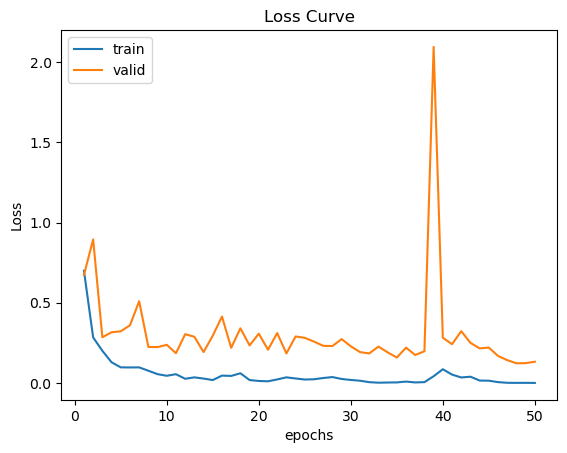

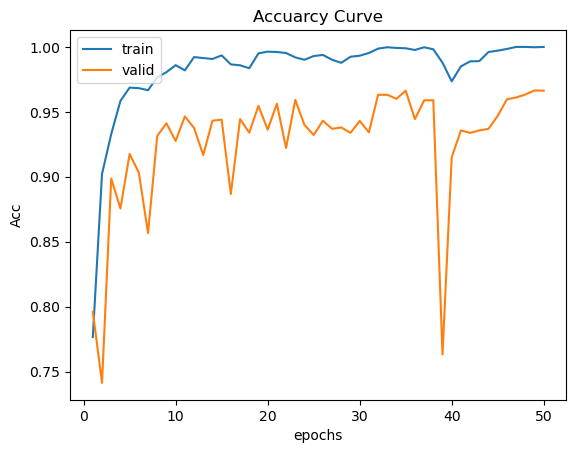

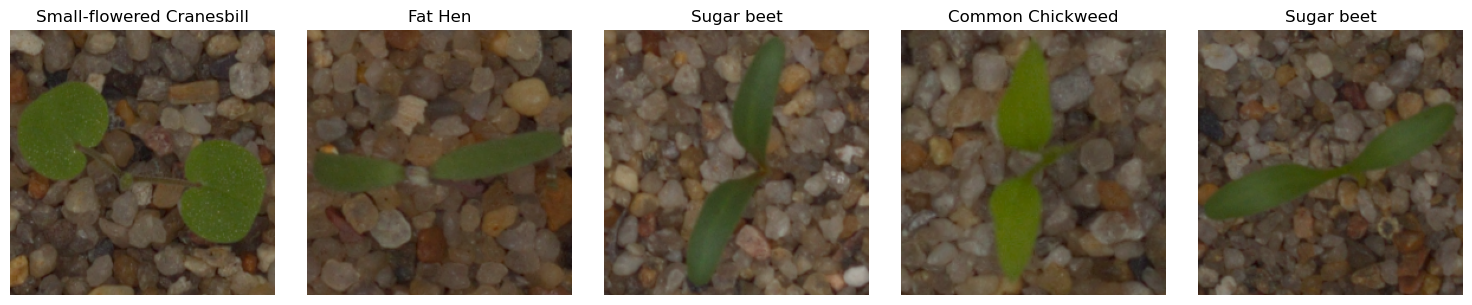

In [20]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = resnet_50(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

## 9. Addition: Customize your own model
Create your own deep learning model, by define the inner layers in hand-craft<br>
Example for VGG16 model: https://arxiv.org/abs/1409.1556

In [22]:
class VGG16(nn.Module):
    def __init__(self, num_classes=12):
        super(VGG16, self).__init__()
        # input layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        #  classifier
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
# Test model to debug
x = torch.rand(1, 3, 224, 224)
model = VGG16(num_classes=12)
y = model(x)
print(y)

tensor([[ 0.1910,  0.1828,  0.0944, -0.0542,  0.0381, -0.1867, -0.0044,  0.2650,
         -0.1580, -0.2994, -0.1169,  0.2207]], grad_fn=<AddmmBackward0>)


Rerun training for VGG16 model

In [24]:
def main():
    # initial transform
    transform = tsfm.Compose([
        tsfm.Resize((224, 224)),
        tsfm.ToTensor(),
    ])

    # initial dataset
    whole_set = Train_data(
        root_dir=train_dir,
        transform=transform
    )

    test_set = Pred_data(
        root_dir=test_dir,
        transform=transform
    )

    # split train valid and initial dataloader
    train_set_size = int(len(whole_set) * 0.8)
    valid_set_size = len(whole_set) - train_set_size
    train_set, valid_set = random_split(whole_set, [train_set_size, valid_set_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size)

    # initial model
    model = VGG16(num_classes=12).cuda()

    # initial loss_function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # initial plot values
    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []
    epoch_list = []

    # repeat train and valid epochs times
    print(epochs)
    for epoch in range(epochs):
      epoch_list.append(epoch + 1)

      loss, acc = train(
          model,
          criterion,
          optimizer,
          train_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      train_loss.append(loss)
      train_acc.append(acc)
      print(f'Avg train Loss: {loss}, Avg train acc: {acc}')

      loss, acc = valid(
          model,
          criterion,
          valid_loader,
          epoch=epoch,
          total_epochs=epochs,
          batch_size=batch_size
      )
      valid_loss.append(loss)
      valid_acc.append(acc)
      print(f'Avg valid Loss: {loss}, Avg valid acc: {acc}')

    Plot("Loss Curve", 'Loss', epoch_list, train_loss, valid_loss)
    Plot("Accuarcy Curve", 'Acc', epoch_list, train_acc, valid_acc)

    preds = predict(test_set, model)
    view_pred_result(preds)

main()

50


Epoch: 0/50 (0%) | Training loss: NaN:   0%|          | 0/60 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacty of 8.00 GiB of which 3.00 MiB is free. Of the allocated memory 6.08 GiB is allocated by PyTorch, and 781.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF